In [2]:
pip install opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [2]:
# Ensure memory growth is enabled for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
data_dir = "E:/Mangrove project/CNN/Data"
class_names = os.listdir(data_dir)
class_names.sort()
print(f'Class names: {class_names}')

Class names: ['Acrostichum aureum', 'Avicennia rumphiana', 'Lumnitzera racemosa', 'Nypa fruticans', 'Rhizophora mucronata']


In [ ]:
image_exts = ['jpeg', 'png', 'jpg', 'bmp']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [42]:
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(256, 256), batch_size=32, label_mode='categorical')
data = data.map(lambda x, y: (x / 255, y))

Found 4991 files belonging to 5 classes.


In [43]:
# Split the dataset
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1) + 1

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [44]:
# Build the model
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [45]:
logdir = "E:/Mangrove project/CNN/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
109/109 [==============================] - 61s 551ms/step - loss: 1.1031 - accuracy: 0.5553 - val_loss: 0.7800 - val_accuracy: 0.6804
Epoch 2/10
109/109 [==============================] - 63s 566ms/step - loss: 0.7126 - accuracy: 0.7165 - val_loss: 0.5615 - val_accuracy: 0.7823
Epoch 3/10
109/109 [==============================] - 64s 584ms/step - loss: 0.5831 - accuracy: 0.7833 - val_loss: 0.4963 - val_accuracy: 0.8306
Epoch 4/10
109/109 [==============================] - 67s 607ms/step - loss: 0.4857 - accuracy: 0.8280 - val_loss: 0.4573 - val_accuracy: 0.8327
Epoch 5/10
109/109 [==============================] - 67s 609ms/step - loss: 0.3887 - accuracy: 0.8779 - val_loss: 0.3478 - val_accuracy: 0.8800
Epoch 6/10
109/109 [==============================] - 67s 605ms/step - loss: 0.3058 - accuracy: 0.8942 - val_loss: 0.3008 - val_accuracy: 0.8992
Epoch 7/10
109/109 [==============================] - 67s 603ms/step - loss: 0.2407 - accuracy: 0.9163 - val_loss: 0.3161 - val_ac

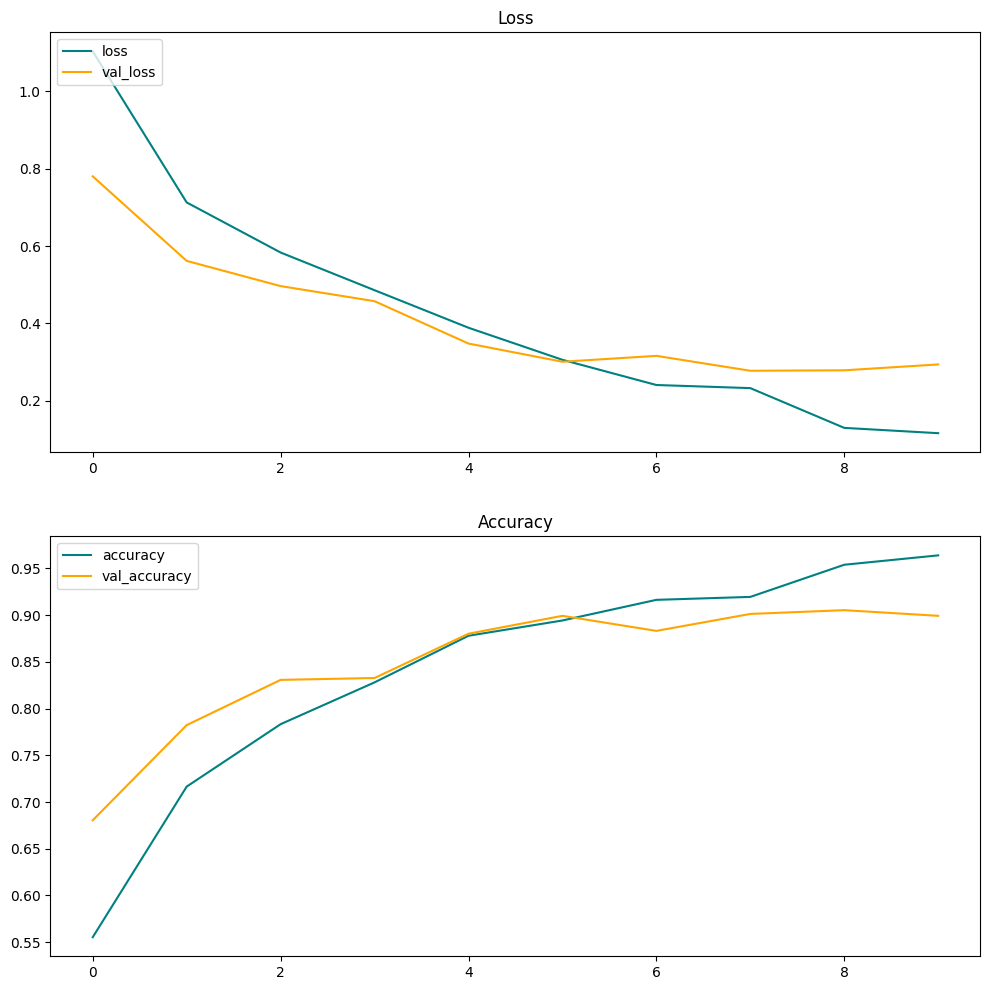

In [46]:
# Plot the training history
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(hist.history['loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
ax[0].set_title('Loss')
ax[0].legend(loc="upper left")

ax[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
ax[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
ax[1].set_title('Accuracy')
ax[1].legend(loc="upper left")

plt.show()

In [47]:
# Evaluate the model
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

1/1 [==============================] - 0s 119ms/step
Precision: 0.9067460298538208, Recall: 0.8943248391151428, Accuracy: 0.8962817788124084


In [48]:
# Save the model
model_path = r"E:\Mangrove project\models\cnn_imageclassifier.h5"
model.save(model_path)

1/1 [==============================] - 0s 71ms/step


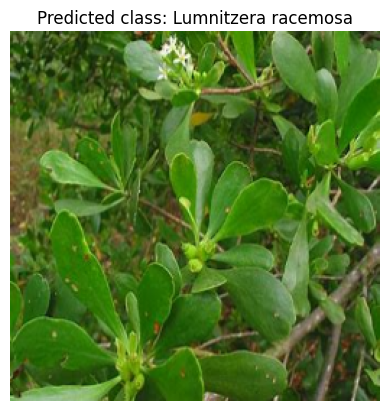

Predicted class probabilities: [[6.8864043e-05 6.6667482e-08 9.9359232e-01 3.8970677e-07 6.3383742e-03]]
Predicted class: Lumnitzera racemosa


In [63]:
# Load and test the model with a new image
model = tf.keras.models.load_model(model_path)

img_path = r"E:\Mangrove project\CNN\lrTest.jpg"
img = cv2.imread(img_path)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Failed to load image at {img_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    resize = tf.image.resize(img, (256, 256))
    input_image = np.expand_dims(resize, 0) / 255.0  # Normalize and add batch dimension

    # Predict
    yhat = model.predict(input_image)
    predicted_class_idx = np.argmax(yhat, axis=1)[0]
    predicted_class_name = class_names[predicted_class_idx]

    # Display results
    plt.imshow(resize.numpy().astype(np.uint8))
    plt.title(f'Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()

    print(f'Predicted class probabilities: {yhat}')
    print(f'Predicted class: {predicted_class_name}')